## Membangun Klasifier Gambar dengan API TensorFlow

Sampai saat ini, Anda telah membangun sebuah klasifier gambar yang bekerja menggunakan jaringan saraf dalam dan Anda telah melihat bagaimana meningkatkan kinerjanya dengan menambahkan konvolusi. Namun, satu keterbatasan adalah bahwa dataset yang digunakan sangat seragam, yaitu gambar pakaian yang dipentaskan dan diframing dalam ukuran 28 x 28. Tapi, apa yang terjadi ketika Anda menggunakan gambar yang lebih besar dan fitur-fitur mungkin berada di lokasi yang berbeda? Misalnya, bagaimana dengan gambar-gambar kuda dan manusia ini? Mereka memiliki ukuran dan rasio aspek yang berbeda. Subjek dapat berada di lokasi yang berbeda, dan dalam beberapa kasus, bahkan mungkin ada beberapa subjek.

Selain itu, contoh sebelumnya dengan data mode menggunakan dataset bawaan. Semua data dengan mudah dibagi menjadi set pelatihan dan pengujian untuk Anda, dan label tersedia. Dalam banyak skenario, itu tidak akan terjadi, dan Anda harus melakukannya sendiri. Dalam pelajaran ini, kita akan melihat beberapa API yang tersedia untuk memudahkan Anda. Khususnya, Anda akan menggunakan API `tf.data` di TensorFlow. Berikut adalah proses secara singkat:

### Proses Pemuatan Data

Anda memiliki sumber data, katakanlah folder gambar, yang dimuat ke dalam objek `tf.data.dataset`. Dari sana, Anda dapat menghubungkan berbagai panggilan metode sebelum memberi data tersebut ke model Anda. Mari kita lihat ini satu per satu, dimulai dengan memuat data input.

#### Memuat Gambar

Anda dapat menggunakan utilitas ini dari Keras untuk memuat gambar sebagai `tf.data.dataset`. Anda cukup menunjuknya ke direktori yang berisi gambar, dan kemudian subdirektori dari itu akan secara otomatis menghasilkan label untuk Anda. 

Misalnya, pertimbangkan struktur direktori ini:

- **images/**
  - **train/**
    - **horses/**
    - **humans/**
  - **val/**

Ketika Anda menempatkan subdirektori di dalam direktori ini untuk kuda dan manusia dan menyimpan gambar yang diperlukan di sana, generator gambar dapat membuat feeder untuk gambar-gambar tersebut dan secara otomatis memberi label. Misalnya, jika saya menunjuk generator gambar ke direktori pelatihan, labelnya akan menjadi kuda dan manusia, dan semua gambar di setiap direktori akan dimuat dan dilabeli sesuai. Begitu pula, jika saya menunjuk ke direktori validasi, hal yang sama akan terjadi.

#### Contoh Kode

Mari kita lihat ini dalam kode. Di sini, saya akan memanggil metode dan menunjuknya ke direktori pelatihan. Ini adalah kesalahan umum bahwa orang menunjuk generator ke subdirektori. Itu akan gagal dalam keadaan itu. Anda harus selalu menunjuknya ke direktori yang berisi subdirektori yang mengandung gambar Anda. Nama-nama subdirektori akan menjadi label untuk gambar-gambar yang ada di dalamnya. Jadi pastikan bahwa direktori yang Anda tunjuk adalah yang benar. Anda menempatkannya di parameter kedua seperti ini.

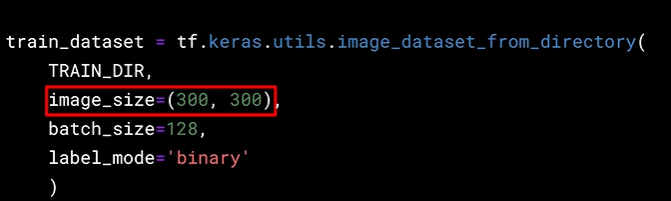

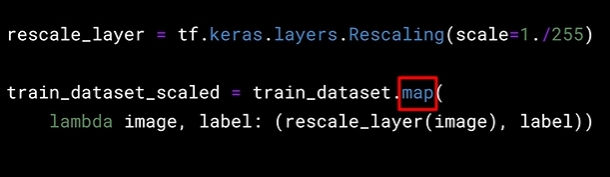

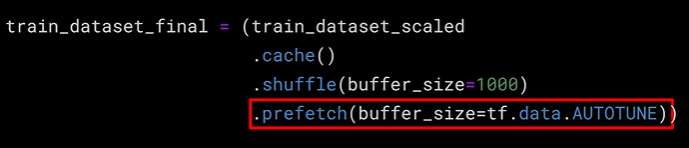

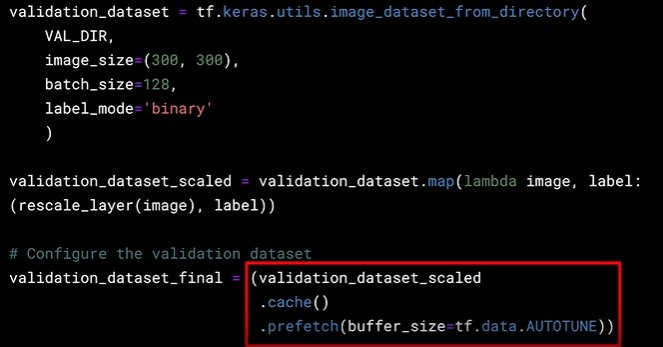

### Mengatur Ukuran Gambar

Sekarang, gambar mungkin datang dalam semua bentuk dan ukuran. Sayangnya, untuk pelatihan jaringan saraf, semua data input harus memiliki ukuran yang sama, jadi gambar-gambar tersebut perlu diubah ukurannya untuk membuatnya konsisten. Kelebihan dari kode ini adalah bahwa gambar-gambar diubah ukurannya untuk Anda saat mereka dimuat, jadi Anda tidak perlu memproses ribuan gambar di sistem file Anda, tetapi Anda bisa melakukannya jika Anda mau. 

Keuntungan melakukan ini saat runtime seperti ini adalah Anda dapat bereksperimen dengan ukuran yang berbeda tanpa mempengaruhi data sumber Anda. Sementara dataset kuda dan manusia sudah dalam ukuran 300 x 300, ketika Anda menggunakan dataset lain, mereka mungkin tidak selalu memiliki ukuran yang seragam. Ini sangat berguna bagi Anda. Gambar-gambar akan dimuat untuk pelatihan dan validasi dalam batch, di mana ini lebih efisien daripada melakukannya satu per satu.

### Menentukan Ukuran Batch

Ada seluruh ilmu dalam menghitung ukuran batch yang berada di luar lingkup kursus ini, tetapi Anda dapat bereksperimen dengan ukuran yang berbeda untuk melihat dampaknya pada kinerja dengan mengubah parameter ini. 

### Mode Label

Akhirnya, ada mode label. Sekarang, ini adalah klasifier biner, yang berarti bahwa ia memilih antara dua hal yang berbeda. Dalam hal ini, kuda dan manusia. Kita akan menentukan itu di sini. Keluaran adalah objek `tf.data.dataset` yang mewakili gambar-gambar Anda. Tipe data ini di TensorFlow memungkinkan Anda untuk mempersiapkan data melalui serangkaian panggilan metode sebelum memberikannya ke model Anda. Rangkaian metode ini disebut sebagai pipeline data, dan Anda dapat melihat dokumentasi yang terhubung di sini untuk semua metode yang tersedia yang dapat Anda terapkan pada dataset.

### Normalisasi Gambar

Seperti yang Anda lakukan di minggu-minggu sebelumnya, Anda ingin menormalkan gambar dengan menskalakan nilai piksel dari 0-1. Anda dapat melakukannya dengan terlebih dahulu menginstansiasi lapisan rescaling seperti yang ditunjukkan di sini. Kemudian gunakan metode map dari dataset untuk menerapkannya pada gambar-gambar. Anda akan memberikan fungsi Lambda yang mengambil gambar dan label dan mengeluarkan pasangan yang sama tetapi dengan gambar yang diubah ukurannya.

Selanjutnya, Anda akan menghubungkan lebih banyak metode untuk mempersiapkan data dan juga mengoptimalkan untuk kinerja. Anda akan menemukan bahwa jika Anda menghapus beberapa dari ini, terutama caching dan prefetching, akan memerlukan lebih banyak waktu bagi model untuk menyelesaikan pelatihan. 

- **Metode Cache**: Menyimpan elemen di memori saat Anda menggunakannya. Ini dapat membuat pengambilan berikutnya lebih cepat, dan sangat berguna saat berulang kali mengulangi gambar saat pelatihan.
- **Metode Shuffle**: Mengacak dataset. Buffer menyimpan sejumlah elemen, dan dari sana, pengacakan terjadi dengan memilih elemen secara acak. Dalam contoh ini, 1.000 gambar pertama awalnya disisihkan dan salah satunya dipilih secara acak sebagai bagian dari dataset shuffle.

### Prefetching

Selanjutnya, prefetching memungkinkan eksekusi paralel. Misalnya, model dapat secara bersamaan memproses gambar sambil gambar berikutnya dibaca ke dalam memori. Ini juga bergantung pada buffer dan dengan mengatur ke `tf.data.autotune`, membiarkan `tf.data` secara otomatis menentukan ukuran pada runtime. 

Anda dapat mempersiapkan dataset validasi dengan menunjuk ke direktori validasi dan melakukan langkah-langkah yang sama seperti sebelumnya. Namun, Anda tidak perlu mengacak data ini, jadi Anda dapat menghapus itu dari panggilan metode di bawah ini. Ketika Anda melalui workbook sebentar lagi, Anda akan melihat bagaimana cara mengunduh gambar sebagai ZIP dan kemudian mengurutkannya ke dalam subdirektori pelatihan dan pengujian, lalu menempatkan subdirektori kuda dan manusia di masing-masing. Itu semua murni Python. Itu bukan TensorFlow atau hal-hal pembelajaran mendalam lainnya, tetapi semuanya dijelaskan untuk Anda di notebook.


## Mengintegrasikan Validasi dalam Pelatihan Jaringan Saraf

Dalam video sebelumnya, Anda melihat bagaimana membangun jaringan saraf konvolusional yang mengklasifikasikan kuda terhadap manusia. Setelah itu, Anda melakukan beberapa pengujian menggunakan gambar yang Anda unduh dari web. Di video ini, Anda akan melihat bagaimana Anda dapat membangun validasi ke dalam loop pelatihan dengan menentukan sekumpulan gambar validasi dan kemudian membiarkan TensorFlow melakukan pengukuran efektivitasnya dengan set tersebut.

### Memuat dan Menyiapkan Data

Seperti sebelumnya, Anda akan mengimpor paket-paket dan kemudian memeriksa data. Data terletak di dua folder terpisah, satu untuk pelatihan dan satu untuk validasi. Anda akan membuat beberapa variabel yang menunjuk ke subdirektori pelatihan dan validasi, dan Anda dapat memeriksa nama file. Ingatlah bahwa nama file tidak selalu dapat diandalkan sebagai label. Misalnya, di sini, label kuda pada data validasi tidak dinamai seperti itu, sementara label manusia sudah dinamai.

Kita juga dapat melakukan pemeriksaan cepat apakah semua data sudah diperoleh. Sepertinya sudah baik, jadi kita bisa melanjutkan. Kita bisa menampilkan beberapa gambar pelatihan seperti yang kita lakukan sebelumnya. Mari kita langsung ke model kita.

### Mendefinisikan Model

Di sini kita mendefinisikan lapisan-lapisan dalam model kita. Ini persis sama seperti sebelumnya. Kita kemudian akan mencetak ringkasan model kita, dan Anda bisa melihat bahwa tidak ada yang berubah. Selanjutnya, kita akan mengompilasi model dengan parameter yang sama seperti sebelumnya.

### Menambahkan Dataset Validasi

Sekarang, di sinilah kita bisa melakukan beberapa perubahan. Selain dataset pelatihan, Anda akan membuat `tf.data.dataset` kedua untuk data validasi. Ini hampir sama alurnya, tetapi ditunjuk ke direktori validasi. Ketika Anda menjalankannya, Anda dapat melihat bahwa itu mengambil gambar dan kelas dari direktori tersebut. Anda kemudian akan melakukan pengukuran ulang dan normalisasi gambar dari kedua dataset, dan Anda bisa menghubungkan metode optimisasi yang sama. Anda tidak perlu mengacak data validasi, jadi itu dihapus di sini.

### Melatih Jaringan

Sekarang mari kita latih jaringan. Perhatikan parameter tambahan untuk memberi tahu model tentang data validasi. Kini, di akhir setiap epoch, selain melaporkan kerugian dan akurasi pada pelatihan, model juga memeriksa set validasi untuk memberikan kerugian dan akurasi di sana. Seiring dengan berjalannya epoch, Anda harus melihat peningkatan yang stabil dengan akurasi validasi sedikit lebih rendah daripada pelatihan. Pada epoch ke-15, Anda bisa melihat bahwa meskipun akurasi pelatihan sempurna, akurasi validasi hanya sekitar 85%, dan ini sesuai dengan yang diharapkan. Set validasi adalah data yang belum pernah dilihat oleh jaringan saraf sebelumnya, jadi Anda akan mengharapkan performanya sedikit lebih rendah.

### Menguji Model dengan Gambar Baru

Mari kita coba beberapa gambar lagi, dimulai dengan kuda putih ini.

- **Gambar 1:** Kita bisa melihat bahwa itu salah diklasifikasikan sebagai manusia.
- **Gambar 2:** Mari kita coba gambar yang sangat lucu ini. Kita bisa melihat bahwa itu diklasifikasikan dengan benar sebagai kuda.
- **Gambar 3:** Mari kita coba beberapa orang. Kita coba wanita ini yang mengenakan gaun biru. Ini adalah gambar yang sangat menarik karena dia membelakangi kamera dan kakinya tertutup oleh gaun, tetapi dia diklasifikasikan dengan benar sebagai manusia.

#### Gambar Sulit

- **Gambar 4:** Berikut adalah gambar yang rumit. Di mata kita, dia manusia, tetapi apakah sayapnya membingungkan jaringan saraf?
  - Mereka membingungkan. Dia dianggap sebagai kuda. Ini bisa dimengerti, terutama karena set pelatihan memiliki banyak kuda putih dengan latar belakang rumput.

#### Gambar Campuran

- **Gambar 5:** Bagaimana dengan yang ini? Ini memiliki kuda dan manusia di dalamnya, tetapi diklasifikasikan sebagai kuda. Kita bisa melihat bahwa fitur dominan dalam gambar adalah kuda, jadi tidak terlalu mengejutkan. Juga, ada banyak kuda putih dalam set pelatihan, jadi mungkin itu yang dikenali.

#### Gambar Terakhir

- **Gambar 6:** Satu terakhir. Saya tidak bisa menahan untuk tidak melihat gambar ini karena sangat menggemaskan, dan syukurlah, itu diklasifikasikan sebagai kuda.

### Kesimpulan

Sekarang kita melihat pelatihan dengan set validasi, dan kita bisa mendapatkan perkiraan yang baik untuk akurasi klasifier dengan melihat hasilnya menggunakan set validasi. Menggunakan hasil ini dan memahami di mana dan mengapa beberapa inferensi gagal dapat membantu Anda memahami bagaimana memodifikasi data pelatihan Anda untuk mencegah kesalahan seperti itu. Tetapi mari kita ganti topik di video berikutnya, dan kita akan melihat dampak dari mengompak data Anda untuk mempercepat pelatihan.
